In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import yaml
import os
from tensorflow.keras.utils import to_categorical

In [2]:
# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [3]:
# Load the raw dataset
print("Loading MixedWM38.npz...")
data = np.load('data/raw/MixedWM38.npz')


Loading MixedWM38.npz...


In [4]:
print("Keys in the dataset:")
for key in data.keys():
    print(f"- {key}: shape = {data[key].shape}, dtype = {data[key].dtype}")

Keys in the dataset:
- arr_0: shape = (38015, 52, 52), dtype = int32
- arr_1: shape = (38015, 8), dtype = int32


In [5]:
images = data['arr_0']
labels = data['arr_1']


In [6]:
print(f"\nImages shape: {images.shape}")
print(f"Labels shape: {labels.shape}")



Images shape: (38015, 52, 52)
Labels shape: (38015, 8)


In [7]:
# Analyze labels structure
print("=== LABELS ANALYSIS ===")
print(f"Labels dtype: {labels.dtype}")
print(f"Unique values in labels: {np.unique(labels)}")

# Check if labels are one-hot encoded
print(f"\nSum of each row in labels: min={np.sum(labels, axis=1).min()}, max={np.sum(labels, axis=1).max()}")
print(f"Number of classes based on label shape: {labels.shape[1]}")


=== LABELS ANALYSIS ===
Labels dtype: int32
Unique values in labels: [0 1]

Sum of each row in labels: min=0, max=4
Number of classes based on label shape: 8


In [8]:
# Count samples per class
if labels.shape[1] > 1:  # Likely one-hot encoded
    class_counts = np.sum(labels, axis=0)
    print(f"\nClass distribution:")
    for i, count in enumerate(class_counts):
        print(f"  Class {i}: {count} samples ({count/len(labels)*100:.2f}%)")
else:
    # If not one-hot encoded
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\nClass distribution:")
    for cls, count in zip(unique, counts):
        print(f"  Class {cls}: {count} samples ({count/len(labels)*100:.2f}%)")


Class distribution:
  Class 0: 13000 samples (34.20%)
  Class 1: 12000 samples (31.57%)
  Class 2: 13000 samples (34.20%)
  Class 3: 12000 samples (31.57%)
  Class 4: 18000 samples (47.35%)
  Class 5: 149 samples (0.39%)
  Class 6: 19000 samples (49.98%)
  Class 7: 866 samples (2.28%)


In [9]:
# Analyze images
print("\n=== IMAGES ANALYSIS ===")
print(f"Images dtype: {images.dtype}")
print(f"Image value range: [{images.min()}, {images.max()}]")
print(f"Image shape: {images.shape}")

# Check for any abnormal values
print(f"Number of NaN values: {np.isnan(images).sum()}")
print(f"Number of Inf values: {np.isinf(images).sum()}")


=== IMAGES ANALYSIS ===
Images dtype: int32
Image value range: [0, 3]
Image shape: (38015, 52, 52)
Number of NaN values: 0
Number of Inf values: 0


In [10]:
# Calculate basic statistics
image_stats = {
    'mean': images.mean(),
    'std': images.std(),
    'min': images.min(),
    'max': images.max(),
    'median': np.median(images)
}

print("\nImage statistics:")
for stat, value in image_stats.items():
    print(f"  {stat}: {value:.4f}")


Image statistics:
  mean: 1.0068
  std: 0.6932
  min: 0.0000
  max: 3.0000
  median: 1.0000


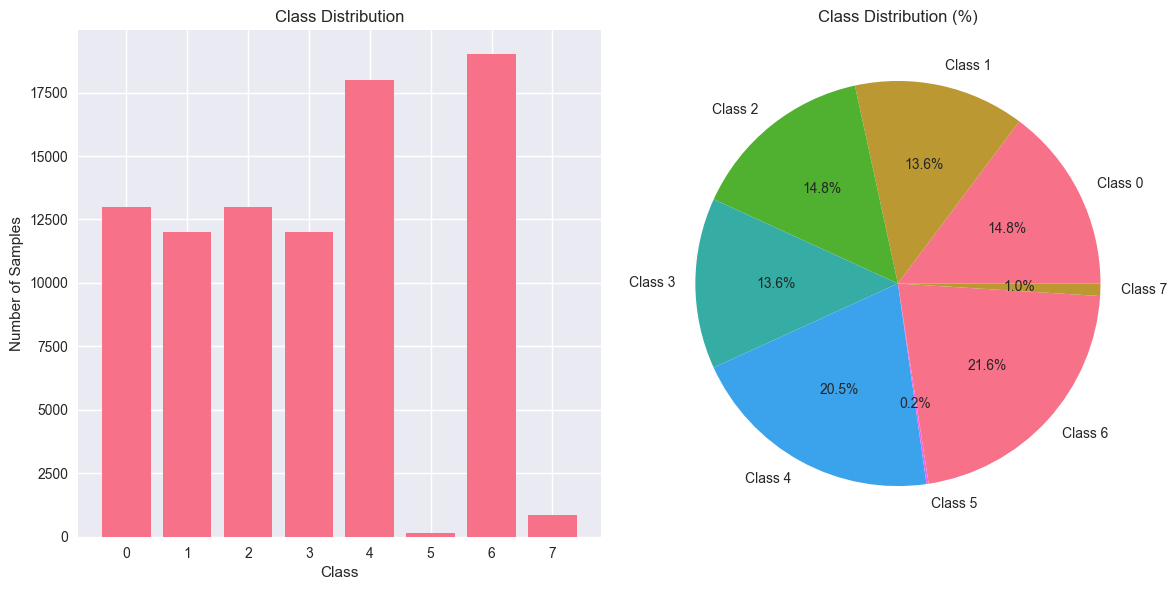

In [11]:
# Visualize label distribution
plt.figure(figsize=(12, 6))

if labels.shape[1] > 1:
    class_counts = np.sum(labels, axis=0)
    classes = range(len(class_counts))
else:
    unique, counts = np.unique(labels, return_counts=True)
    class_counts = counts
    classes = unique

plt.subplot(1, 2, 1)
plt.bar(classes, class_counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(classes)

plt.subplot(1, 2, 2)
plt.pie(class_counts, labels=[f'Class {i}' for i in classes], autopct='%1.1f%%')
plt.title('Class Distribution (%)')

plt.tight_layout()
plt.show()


In [12]:
# Calculate class weights for handling imbalance
if labels.shape[1] > 1:
    y_flat = np.argmax(labels, axis=1)
else:
    y_flat = labels.flatten()

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_flat),
    y=y_flat
)

print("Class weights for handling imbalance:")
for cls, weight in zip(np.unique(y_flat), class_weights):
    print(f"  Class {cls}: {weight:.4f}")

Class weights for handling imbalance:
  Class 0: 0.3394
  Class 1: 0.3960
  Class 2: 1.1880
  Class 3: 1.1880
  Class 4: 2.3759
  Class 5: 31.8918
  Class 6: 4.7519
  Class 7: 5.4872



=== SAMPLE IMAGES FROM EACH CLASS ===


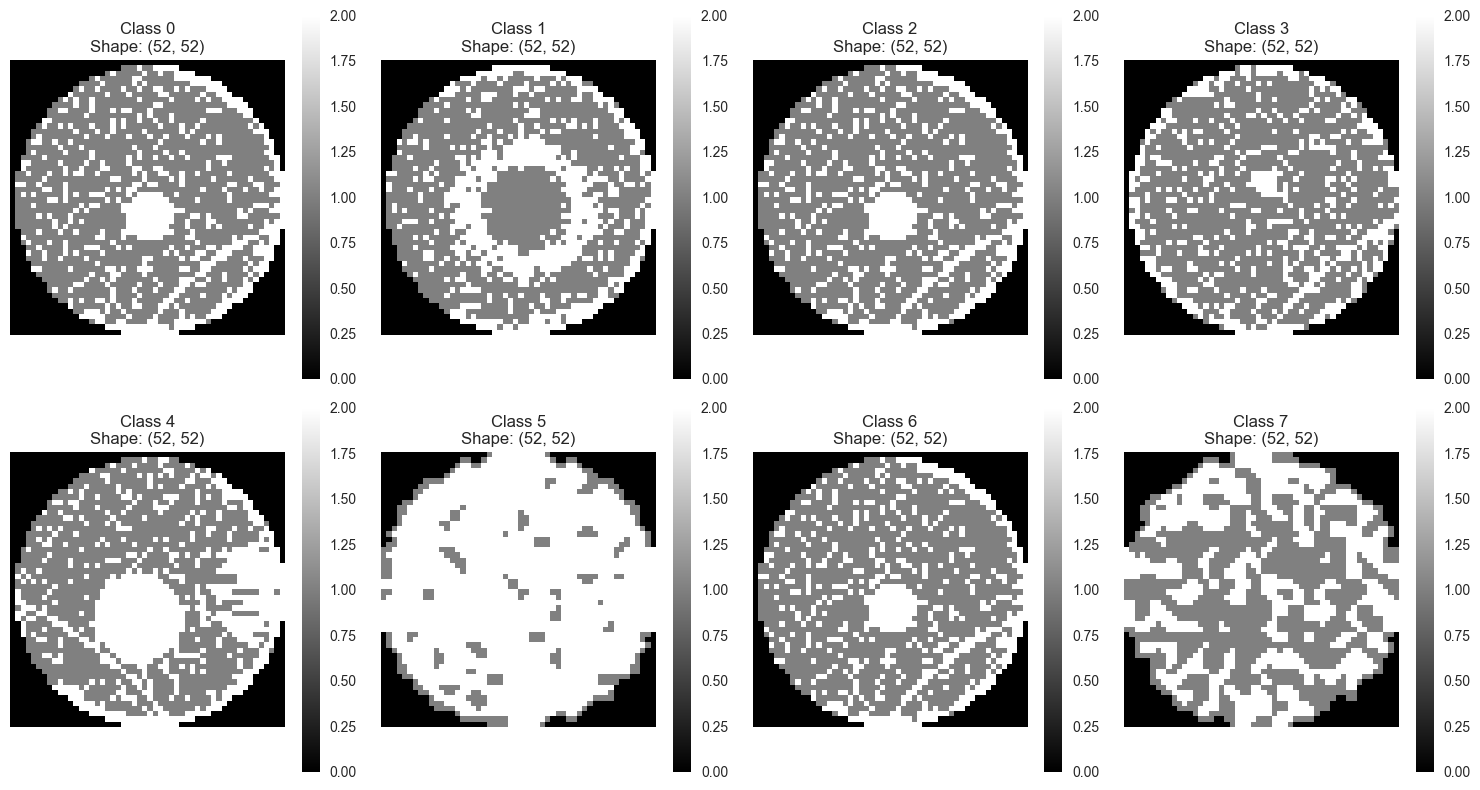

In [13]:
# Visualize sample images from each class
print("\n=== SAMPLE IMAGES FROM EACH CLASS ===")

# Get one sample from each class
samples_per_class = []
class_names = []

if labels.shape[1] > 1:
    for class_idx in range(labels.shape[1]):
        class_indices = np.where(labels[:, class_idx] == 1)[0]
        if len(class_indices) > 0:
            samples_per_class.append(images[class_indices[0]])
            class_names.append(f'Class {class_idx}')
else:
    for class_idx in np.unique(labels):
        class_indices = np.where(labels == class_idx)[0]
        if len(class_indices) > 0:
            samples_per_class.append(images[class_indices[0]])
            class_names.append(f'Class {class_idx}')

# Plot samples
n_cols = 4
n_rows = (len(samples_per_class) + n_cols - 1) // n_cols

plt.figure(figsize=(15, 4 * n_rows))
for i, (img, class_name) in enumerate(zip(samples_per_class, class_names)):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'{class_name}\nShape: {img.shape}')
    plt.colorbar()
    plt.axis('off')

plt.tight_layout()
plt.show()



=== PIXEL VALUE DISTRIBUTION ===


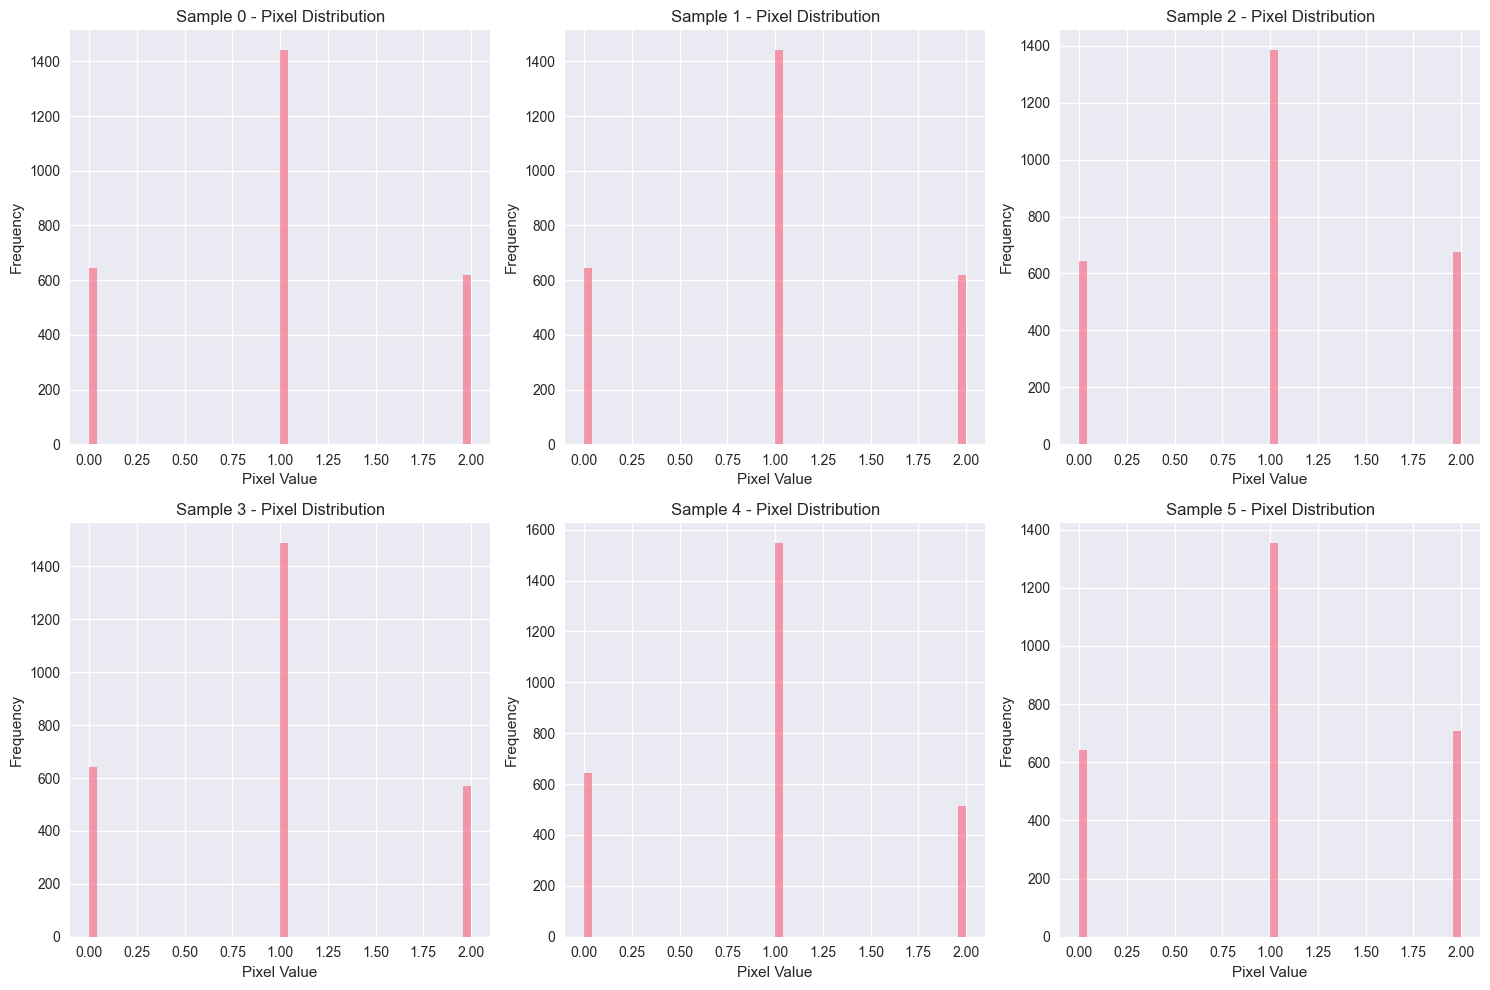

In [14]:
# Analyze pixel value distribution for a few samples
print("\n=== PIXEL VALUE DISTRIBUTION ===")

plt.figure(figsize=(15, 10))

# Plot histogram for first few samples
for i in range(min(6, len(images))):
    plt.subplot(2, 3, i + 1)
    plt.hist(images[i].flatten(), bins=50, alpha=0.7)
    plt.title(f'Sample {i} - Pixel Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



=== IMAGE QUALITY ANALYSIS ===


<Axes: >

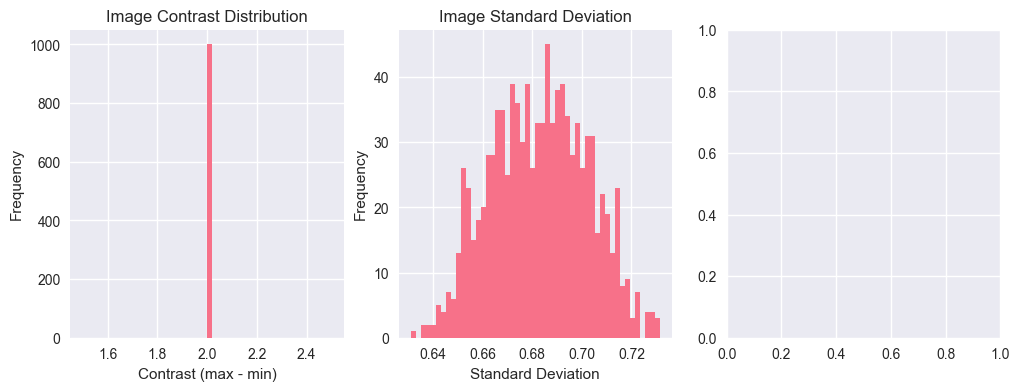

In [15]:
# Check image quality and artifacts
print("\n=== IMAGE QUALITY ANALYSIS ===")

# Calculate contrast for each image
contrasts = []
for i in range(min(1000, len(images))):  # Sample first 1000 images
    img = images[i]
    contrasts.append(img.max() - img.min())

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(contrasts, bins=50)
plt.title('Image Contrast Distribution')
plt.xlabel('Contrast (max - min)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
# Check for constant images (no variation)
std_devs = [img.std() for img in images[:1000]]
plt.hist(std_devs, bins=50)
plt.title('Image Standard Deviation')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)

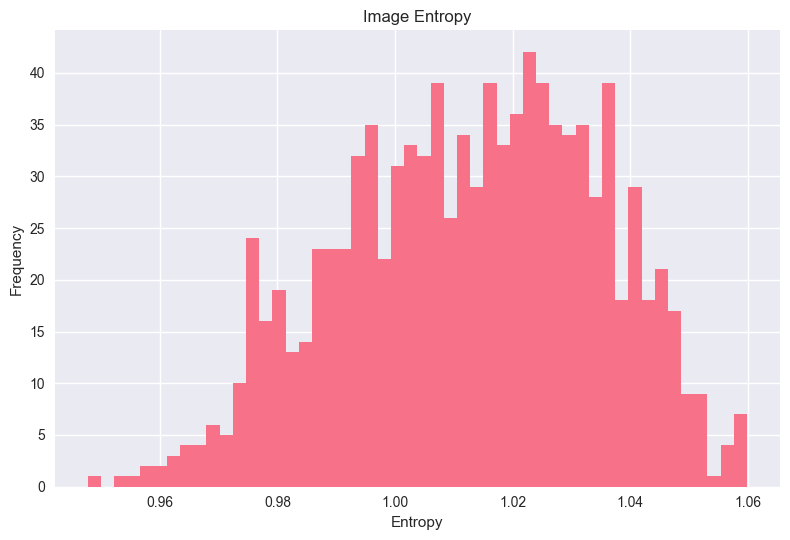

Number of constant images (std=0): 0
Average contrast: 2.00
Average entropy: 1.01


In [16]:
# Check image entropy (rough measure of information content)
from scipy.stats import entropy

def image_entropy(img):
    hist, _ = np.histogram(img, bins=256, range=(0, 255))
    hist = hist[hist > 0]  # Remove zero bins for entropy calculation
    return entropy(hist)

entropies = [image_entropy(img) for img in images[:1000]]
plt.hist(entropies, bins=50)
plt.title('Image Entropy')
plt.xlabel('Entropy')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Number of constant images (std=0): {sum(np.array(std_devs) == 0)}")
print(f"Average contrast: {np.mean(contrasts):.2f}")
print(f"Average entropy: {np.mean(entropies):.2f}")


In [17]:
# Data preprocessing validation
print("\n=== PREPROCESSING VALIDATION ===")

# Test the preprocessing steps
test_images = images[:100].copy()  # Use a subset for testing

print("Original images:")
print(f"  Shape: {test_images.shape}")
print(f"  Value range: [{test_images.min()}, {test_images.max()}]")
print(f"  Dtype: {test_images.dtype}")



=== PREPROCESSING VALIDATION ===
Original images:
  Shape: (100, 52, 52)
  Value range: [0, 2]
  Dtype: int32


In [18]:
# Step 1: Add channel dimension
if len(test_images.shape) == 3:
    test_images = np.expand_dims(test_images, axis=-1)
    print(f"\nAfter adding channel dimension:")
    print(f"  Shape: {test_images.shape}")

# Step 2: Convert to 3 channels if needed
if test_images.shape[-1] == 1:
    test_images = np.repeat(test_images, 3, axis=-1)
    print(f"After converting to 3 channels:")
    print(f"  Shape: {test_images.shape}")

# Step 3: Normalize
test_images = test_images.astype('float32') / 255.0
print(f"After normalization:")
print(f"  Value range: [{test_images.min():.3f}, {test_images.max():.3f}]")
print(f"  Dtype: {test_images.dtype}")



After adding channel dimension:
  Shape: (100, 52, 52, 1)
After converting to 3 channels:
  Shape: (100, 52, 52, 3)
After normalization:
  Value range: [0.000, 0.008]
  Dtype: float32


In [19]:
# Verify label encoding
print("\n=== LABEL ENCODING VERIFICATION ===")

if labels.shape[1] > 1:
    print("Labels appear to be one-hot encoded")
    # Verify they are proper one-hot
    row_sums = np.sum(labels, axis=1)
    if np.all(row_sums == 1):
        print("✓ Labels are properly one-hot encoded (each row sums to 1)")
        labels_categorical = labels
    else:
        print("⚠ Labels are not properly one-hot encoded, converting...")
        labels_flat = np.argmax(labels, axis=1)
        labels_categorical = to_categorical(labels_flat)
        print(f"  Converted to categorical with {labels_categorical.shape[1]} classes")
else:
    print("Labels are not one-hot encoded, converting...")
    labels_flat = labels.flatten()
    labels_categorical = to_categorical(labels_flat)
    print(f"  Converted to categorical with {labels_categorical.shape[1]} classes")

print(f"Final categorical labels shape: {labels_categorical.shape}")



=== LABEL ENCODING VERIFICATION ===
Labels appear to be one-hot encoded
⚠ Labels are not properly one-hot encoded, converting...
  Converted to categorical with 8 classes
Final categorical labels shape: (38015, 8)


In [21]:
# Data splitting analysis
print("\n=== DATA SPLITTING ANALYSIS ===")

from sklearn.model_selection import train_test_split

# Get flat labels for stratification
labels_flat = np.argmax(labels_categorical, axis=1)

test_size = 0.2
val_size = 0.15
random_state = 42

# Calculate actual validation size relative to train+val
val_relative_size = val_size / (1 - test_size)

X_temp, X_test, y_temp, y_test = train_test_split(
    images, labels_categorical, 
    test_size=test_size,
    random_state=random_state,
    stratify=labels_flat
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_relative_size,
    random_state=random_state,
    stratify=np.argmax(y_temp, axis=1)
)

print(f"Original dataset: {images.shape[0]} samples")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/images.shape[0]*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/images.shape[0]*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/images.shape[0]*100:.1f}%)")

# Verify stratification worked
print("\nClass distribution in splits:")
print("Class | Train | Val   | Test")
print("-" * 30)
for class_idx in range(labels_categorical.shape[1]):
    train_pct = np.sum(y_train[:, class_idx]) / len(y_train) * 100
    val_pct = np.sum(y_val[:, class_idx]) / len(y_val) * 100
    test_pct = np.sum(y_test[:, class_idx]) / len(y_test) * 100
    print(f"{class_idx:5} | {train_pct:5.1f}% | {val_pct:5.1f}% | {test_pct:5.1f}%")




=== DATA SPLITTING ANALYSIS ===
Original dataset: 38015 samples
Training set: 24709 samples (65.0%)
Validation set: 5703 samples (15.0%)
Test set: 7603 samples (20.0%)

Class distribution in splits:
Class | Train | Val   | Test
------------------------------
    0 |  36.8% |  36.8% |  36.8%
    1 |  31.6% |  31.6% |  31.6%
    2 |  10.5% |  10.5% |  10.5%
    3 |  10.5% |  10.5% |  10.5%
    4 |   5.3% |   5.3% |   5.3%
    5 |   0.4% |   0.4% |   0.4%
    6 |   2.6% |   2.6% |   2.6%
    7 |   2.3% |   2.3% |   2.3%


In [22]:
# Model input compatibility check
print("\n=== MODEL COMPATIBILITY CHECK ===")

# Check if images are compatible with common CNN architectures
target_size = (52, 52)
print(f"Image size: {images.shape[1:3]}")
print(f"Target size for models: {target_size}")

if images.shape[1:3] == target_size:
    print("✓ Image size matches common CNN input requirements")
else:
    print("⚠ Image size may need resizing for some models")

# Check memory requirements
image_memory_gb = images.nbytes / (1024 ** 3)
model_memory_estimate_gb = image_memory_gb * 3  # Rough estimate for training

print(f"\nMemory requirements:")
print(f"  Dataset size: {image_memory_gb:.2f} GB")
print(f"  Estimated training memory: {model_memory_estimate_gb:.2f} GB")



=== MODEL COMPATIBILITY CHECK ===
Image size: (52, 52)
Target size for models: (52, 52)
✓ Image size matches common CNN input requirements

Memory requirements:
  Dataset size: 0.38 GB
  Estimated training memory: 1.15 GB


In [23]:
# Recommendations based on analysis
print("\n=== RECOMMENDATIONS ===")

print("1. DATA PREPROCESSING:")
print("   ✓ Normalize pixel values to [0, 1]")
print("   ✓ Convert grayscale to 3 channels for pretrained models")
print("   ✓ Use stratified splitting to maintain class distribution")

print("\n2. MODEL TRAINING:")
if min(class_counts) / max(class_counts) < 0.1:
    print("   ⚠ Significant class imbalance detected - use class weights")
else:
    print("   ✓ Class distribution is reasonably balanced")

print("   ✓ Consider using transfer learning with EfficientNetB0")
print("   ✓ Use image augmentation to improve generalization")

print("\n3. TRAINING STRATEGY:")
print("   ✓ Start with frozen base model")
print("   ✓ Use learning rate scheduling")
print("   ✓ Monitor validation accuracy closely")

print("\n4. POTENTIAL ISSUES:")
if np.any(np.array(std_devs) == 0):
    print("   ⚠ Some images have zero variance (constant)")
if images.max() > 1.0:
    print("   ⚠ Images need normalization")
if labels.shape[1] != 8:
    print(f"   ⚠ Unexpected number of classes: {labels.shape[1]}")



=== RECOMMENDATIONS ===
1. DATA PREPROCESSING:
   ✓ Normalize pixel values to [0, 1]
   ✓ Convert grayscale to 3 channels for pretrained models
   ✓ Use stratified splitting to maintain class distribution

2. MODEL TRAINING:
   ⚠ Significant class imbalance detected - use class weights
   ✓ Consider using transfer learning with EfficientNetB0
   ✓ Use image augmentation to improve generalization

3. TRAINING STRATEGY:
   ✓ Start with frozen base model
   ✓ Use learning rate scheduling
   ✓ Monitor validation accuracy closely

4. POTENTIAL ISSUES:
   ⚠ Images need normalization


In [25]:
# Save analysis report
analysis_report = {
    'dataset_info': {
        'total_samples': images.shape[0],
        'image_shape': images.shape[1:],
        'num_classes': labels_categorical.shape[1],
        'class_distribution': class_counts.tolist() if hasattr(class_counts, 'tolist') else class_counts,
    },
    'preprocessing': {
        'normalization_required': images.max() > 1.0,
        'channel_expansion_required': len(images.shape) == 3,
        'label_encoding_required': labels.shape[1] != labels_categorical.shape[1],
    },
    'recommendations': {
        'use_class_weights': min(class_counts) / max(class_counts) < 0.1,
        'suggested_model': 'EfficientNetB0',
        'batch_size_suggestion': 32,
    }
}



In [26]:
# Save report
import json
os.makedirs('reports', exist_ok=True)
with open('reports/data_analysis_report.json', 'w') as f:
    json.dump(analysis_report, f, indent=2)

print(f"\nAnalysis report saved to 'reports/data_analysis_report.json'")


TypeError: Object of type bool is not JSON serializable